In [1]:
import pandas as pd
import spacy
from tinydb import TinyDB, Query
import spacy
from collections import defaultdict, Counter
from nltk.util import ngrams
import matplotlib.pyplot as plt
#from wordcloud import WordCloud
import itertools
import string
import numpy as np

In [2]:
db = TinyDB('../4chan_pol_database.json')
spacy_en_core = spacy.load('en_core_web_sm')

In [3]:
initial_keywords =  ["jew","kike","zionist","israel","shylock","yid"]

In [4]:
# restructuring (should be for whole data set)
restructured_dataset = defaultdict(dict)

for t in db.all():
    t = dict(t)
    thread_id = t["thread"]
    t.pop("thread")
    restructured_dataset[thread_id] = t


In [5]:
keyword_threads = []

for thread_id, thread in restructured_dataset.items():
    if any([True for x in initial_keywords if x in thread["initial_comment"]]):
        keyword_threads.append({thread_id: thread})
    else:
        continue
        

In [6]:
def remove_stopwords(words):
    all_stopwords = spacy_en_core.Defaults.stop_words
    tokens_without_sw = [word for word in words if not word in all_stopwords]
    punctuations = [".",",","-","\"",":","?","!","\'"]
    tokens_without_sw = [word for word in tokens_without_sw if not word in punctuations]
    return tokens_without_sw
    
def find_coocs(comment,n_gram_range,word):
    comment = remove_stopwords(comment)
    comment_n_grams = list(ngrams(comment,n_gram_range))
    
    coocs = []

    for gram in comment_n_grams:
        if gram[int(n_gram_range/2)] == word:
            coocs.append(list(gram))
    return coocs  

In [7]:
# analyse coocs
keyword_coocs = defaultdict(list)

for kw_thread in keyword_threads:
   
    for word in initial_keywords:
        value, = kw_thread.values()
        coocs = find_coocs(value["initial_comment"],7,word)
        if coocs:
            keyword_coocs[word].append(coocs)
    

In [11]:
print(keyword_coocs)

defaultdict(<class 'list'>, {'israel': [[['concentration', 'camp', 'commander', 'israel', 'protected', "''", 'describitive']], [['laid', 'plan', 'zionism', 'israel', 'th', 'centry', 'shit']], [['.', 'simp', 'palestine', 'israel', 'ur', 'fag', 'kill']], [['whites', 'benefit', 'expanding', 'israel', '.', 'israel', 'grows'], ['expanding', 'israel', '.', 'israel', 'grows', 'stronger', ','], ['refugee', 'sent', 'europe', 'israel', ',', 'zog', 'run'], ['whites', 'blames', 'whites', 'israel', '.', 'palestinians', 'allowed'], ['palestinians', 'allowed', 'home', 'israel', 'wont', 'let', '.'], ['return', 'palestine', ',', 'israel', 'lose', 'influence', 'power']], [['.', 'palestine', '-', 'israel', 'conflict', ',', 'read']], [['sand', 'niggers', '.', 'israel', 'threat', ',', 'palestine'], ['support', 'enemy', 'aggressor', 'israel', '.', 'palestine', 'long'], ['sand', 'niggers.anything', 'means', 'israel', 'empire', 'claiming', 'victim']], [['need', 'existence', 'greater', 'israel', 'order', 'send

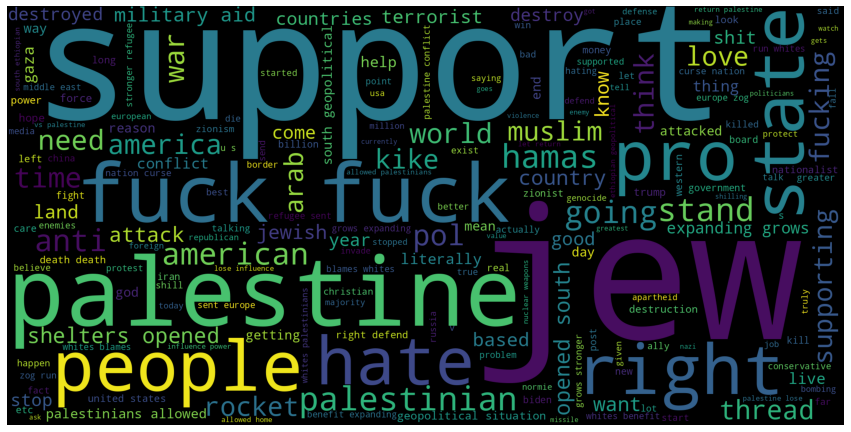

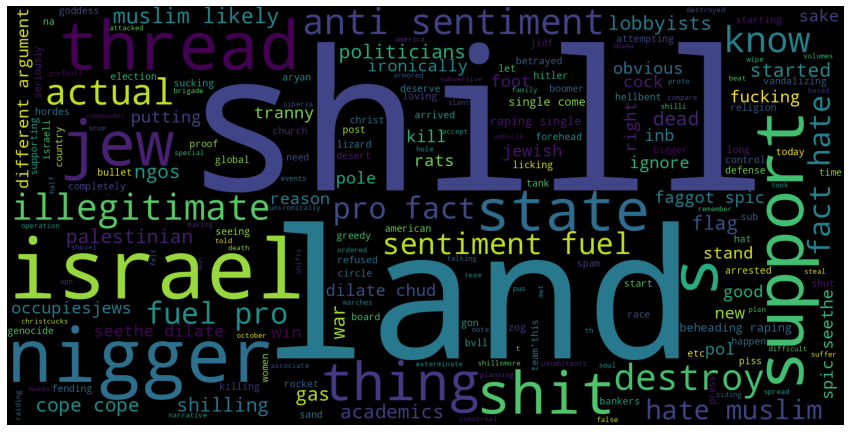

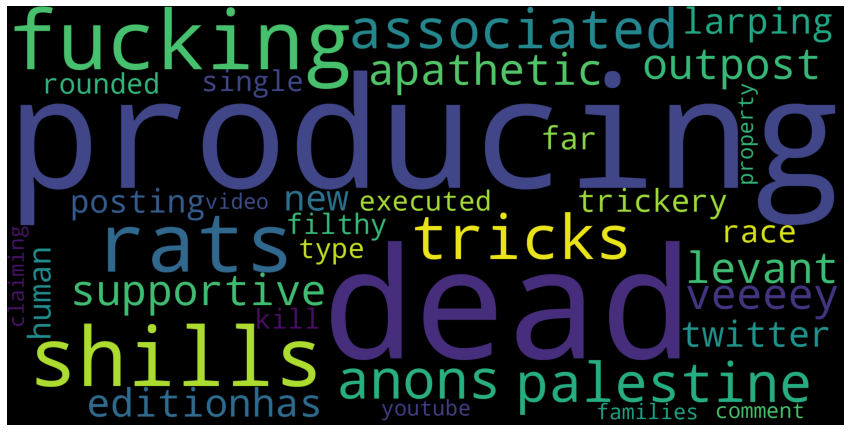

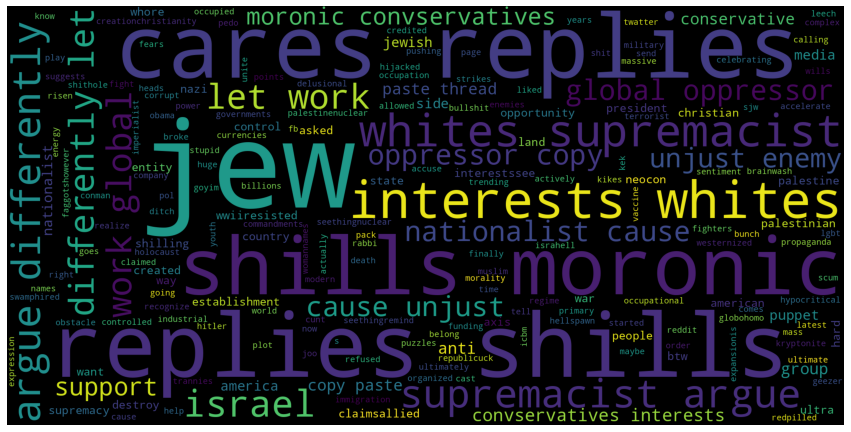

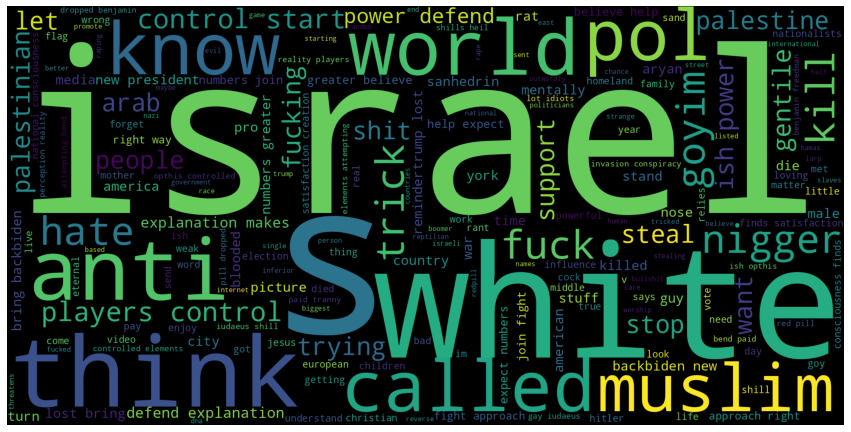

In [33]:
for keyword in keyword_coocs:
    coocs = list(itertools.chain.from_iterable(keyword_coocs[keyword]))
    coocs = list(itertools.chain.from_iterable(coocs))
   
    cooc_string = (" ").join(coocs).replace(keyword,"")  

    wordcloud = WordCloud(width = 2000, height = 1000).generate(cooc_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig(keyword+".png", bbox_inches='tight')
    plt.show()
    plt.close()
    

In [12]:
def getTFIDF(threads):

    tfidf = defaultdict(dict)
    t = defaultdict(dict)
    N = len(threads)
    counter = 0

    for thread in threads:
        docText = threads[thread].get("initial_comment")
        for word in docText:

            word = word.translate(str.maketrans('', '', string.punctuation)) #removes punctuation
            count = t[word].get(thread,0)
            t[word][thread] = count + 1
            
    for word in t:
        dk = len(t[word])
        for thread in t[word]:

            D = len(threads[thread]["initial_comment"])
            wordFreq = t[word][thread]
            tfidf[thread][word] = calculateTFIDF(N,dk,wordFreq,D)

    return tfidf


def calculateTFIDF(N,dk,wordFreq,D):
    '''
    Calculates the TFIDF.
    :param N:           number of documents in corpus
    :param dk:          count of documents a token appears in
    :param wordFreq:    How often the token appears in the specific document
    :param D:           length of the specific document
    :return:
    '''
    tf = wordFreq/D
    idf = np.log(N/dk)+1 #I took the formula out of our lecture script

    return tf*idf

In [13]:
tfidf_all = getTFIDF(restructured_dataset)
tfidf_all

defaultdict(dict,
            {321155785: {'jews': 0.05067233601335215,
              'stabbing': 0.12946172960240038,
              'and': 0.05346327468577931,
              'killing': 0.07587302997596554,
              'shitskin': 0.19879849835279167,
              'trannies': 0.16677491367839933,
              'kek': 0.08694409268303055,
              'who': 0.04725416457791065,
              'would': 0.10120612233538022,
              '’': 0.11736208442966549,
              've': 0.0656681008642603,
              'thought': 0.07447488157215966,
              'kikes': 0.06647419152231403,
              'be': 0.0384056148105631,
              'this': 0.03432822376578984,
              'based': 0.06220857092104124,
              '': 0.06761795716616067,
              'westerners': 0.10990877037353108,
              'should': 0.05683848190019039,
              'do': 0.037432777573817425,
              'the': 0.091111909392994,
              'same': 0.06459802334860842,
              'i

In [8]:
# identify words

keyword_coocs_counts = defaultdict()

for keyword, coocs in keyword_coocs.items():
    keyword_dict = defaultdict(int)
    
    for cooc_list in coocs:
        for cooc in cooc_list:
            for word in cooc:
                keyword_dict[word] += 1
                
    keyword_coocs_counts[keyword] = keyword_dict
    
    k = Counter(keyword_coocs_counts[keyword])
  
    # Finding 3 highest values
    high = k.most_common(10) 
    
    print(keyword)
    print(high)
    
                

israel
[('israel', 2358), ('jews', 150), ('palestine', 135), ('support', 129), ('fuck', 107), ('right', 70), (')', 59), ('(', 59), ('palestinians', 58), ('people', 58)]
kike
[('kike', 198), ('shills', 11), ('land', 11), ('like', 10), ('israel', 9), ('nigger', 9), ('support', 8), ('academics', 8), ('ngos', 8), ('pro', 7)]
yid
[('yid', 6), ('producing', 2), ('dead', 2), ('fucking', 2), ('rats', 2), ('shills', 2), ('invited', 2), ('alive', 1), ('killed', 1), ("''", 1)]
zionist
[('zionist', 99), ('jews', 19), ('shills', 13), ('cause', 13), ('interests', 9), ('cares', 8), ("''", 8), ('replies', 8), ('moronic', 8), ('defacto', 8)]
jew
[('jew', 369), ('(', 22), (')', 19), ('like', 19), ('israel', 19), ('jews', 16), ('white', 16), ('think', 15), ('believe', 13), ('jewish', 12)]


In [ ]:
# search again